In [87]:
import numpy as np
import torch
import tqdm
from matplotlib import pyplot as plt

In [26]:
x = np.load('/tmp/result_max_distances.npy')
y = np.load('/tmp/result_number_of_plots.npy')

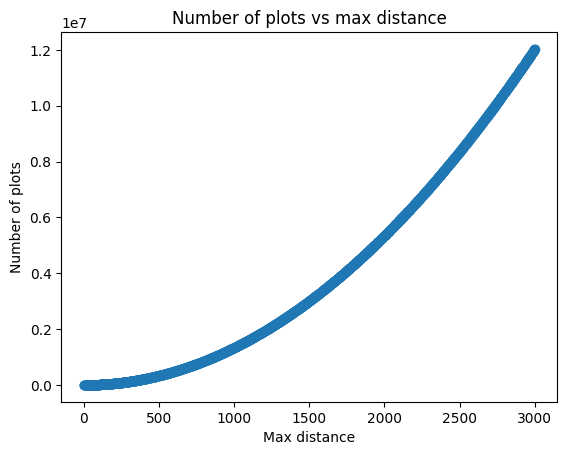

In [27]:
plt.plot(x, y, 'o')
plt.xlabel('Max distance')
plt.ylabel('Number of plots')
plt.title('Number of plots vs max distance')
None

In [51]:
test_frac = 0.5
train_x = x[:int(len(x) * test_frac)]
train_y = y[:int(len(y) * test_frac)]
test_x = x[int(len(x) * test_frac):]
test_y = y[int(len(y) * test_frac):]

In [52]:
coefficients = np.polyfit(train_x, train_y, 2)
print(coefficients)
pred_y = np.polyval(coefficients, test_x)
errors = abs(pred_y - test_y)
mae = np.mean(errors)
mae

[   1.3388449    -2.70643454 -100.92670308]


1084.4438296017026

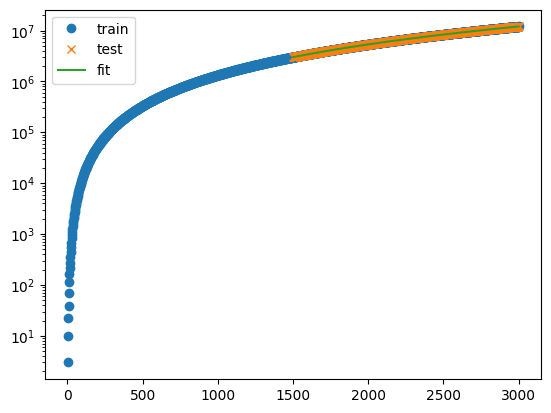

In [53]:
plt.plot(x, y, 'o', label='train')
plt.plot(test_x, test_y, 'x', label='test')
plt.plot(test_x, pred_y, label='fit')
plt.legend()
plt.yscale('log')
None

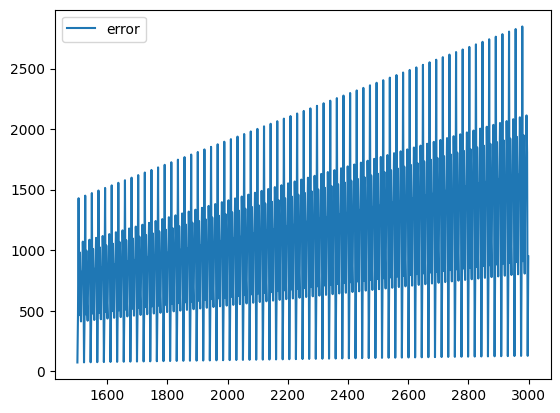

In [54]:
plt.plot(test_x, errors, label='error')
plt.legend()

In [45]:
_ = np.argsort(errors)
period = _[-1] - _[-2]
offset = _[-1] % period
value_increase_between_periods = errors[_[-1]] - errors[_[-2]]
value_increase_per_step = value_increase_between_periods / period
period, offset, value_increase_between_periods, value_increase_per_step


(11, 2, 21.108863098546863, 1.9189875544133512)

In [55]:
hist = errors[:period]

In [60]:
test_hist = hist[test_x % period]
test_hist.shape

(750,)

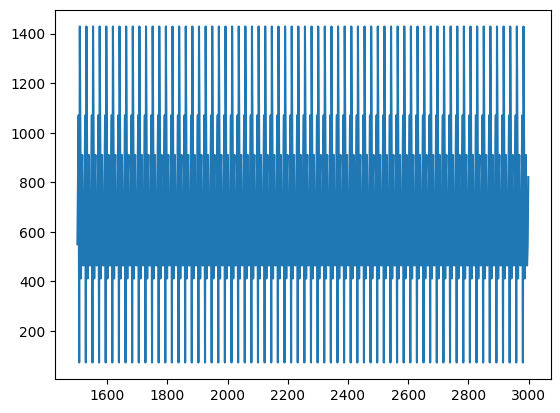

In [89]:
plt.plot(test_x, test_hist, label='hist')
None

In [163]:
A = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)
B = torch.tensor(0, dtype=torch.float32, requires_grad=True)
C = torch.tensor(1, dtype=torch.float32, requires_grad=True)
D = torch.tensor(700, dtype=torch.float32, requires_grad=True)
E = torch.tensor(2000, dtype=torch.float32, requires_grad=True)
optimizer = torch.optim.Adam([A, B, C, D, E], lr=1)
test_hist_tensor = torch.tensor(test_hist, requires_grad=False)
test_x_tensor = torch.tensor(test_x, requires_grad=False)
test_y_tensor = torch.tensor(test_y, requires_grad=False)

In [164]:
def expr(*, hist, x, a, b, c, d, e):
    return (hist - d) * c * (x - e) + x * a + b

In [153]:
def optimize(epochs: int) -> float:
    losses = []
    for _ in tqdm.trange(epochs, desc='Epochs'):
        optimizer.zero_grad()
        preds = expr(hist=test_hist_tensor, x=test_x_tensor, a=A, b=B, c=C, d=D, e=E)
        loss = torch.mean(abs(preds - test_y_tensor))
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy().item())
    plt.plot(losses, label='loss')
    plt.show()

Epochs: 100%|██████████| 1000000/1000000 [14:03<00:00, 1185.62it/s]


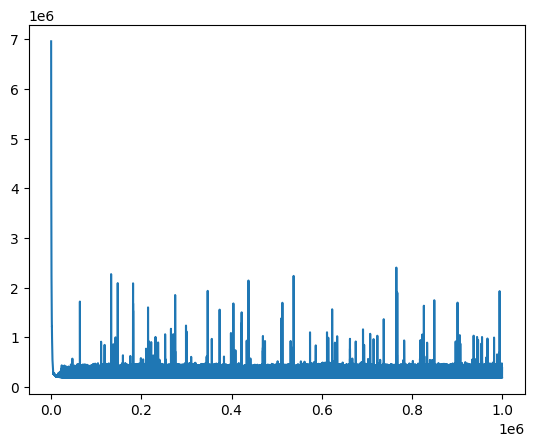

LOSS None
A 3166.326416015625
B -49901.5
C 0.4642687439918518
D -5264.04833984375
E 2291.52587890625


In [154]:
optimize(1000000)

In [165]:
error_preds = expr(
    hist=test_hist,
    x=test_x,
    a=A.detach().numpy(),
    b=B.detach().numpy(),
    c=C.detach().numpy(),
    d=D.detach().numpy(),
    e=E.detach().numpy(),
)

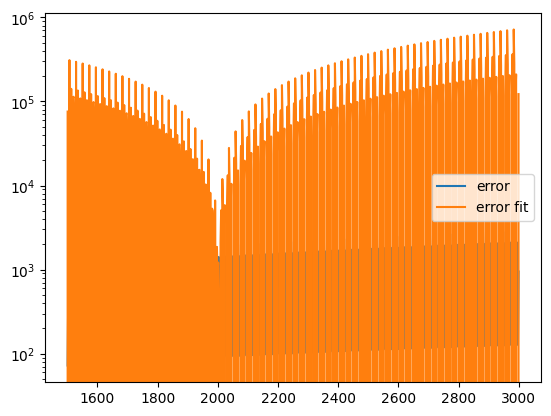

In [166]:
plt.plot(test_x, errors, label='error')
plt.plot(test_x, error_preds, label='error fit')
plt.yscale('log')
plt.legend()